In [25]:
import numpy as np
import pandas as pd
import xgboost as xgb
import random
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import statistics
import matplotlib.pyplot as plt

In [26]:
# Step 1: Prepare the Data
def create_lagged_features(data, n_lags):
    """
    Create lagged features for a univariate time series.
    :param data: 1D array or list of time series data
    :param n_lags: Number of lagged observations to use as features
    :return: Pandas DataFrame with lagged features and target
    """
    df = pd.DataFrame({'y': data})
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df['y'].shift(lag)
    df.dropna(inplace=True)
    return df

# Example time series data (stationary)
random.seed(61)
# data = np.random.normal(50, 10, 200)  # Simulated demand data
n_points = 1500
noise_std = random.uniform(-50,50)  # Standard deviation of white noise
base_demand = random.randint(100,175)  # Shift to ensure positivity

# Initialize the series
demand = []  # Start with a positive base demand
noise = np.random.uniform(0, noise_std, n_points)

for t in range(0, n_points):
    next_value = base_demand + noise[t]
    demand.append(next_value)

data = np.array(demand)
n_lags = 10  # Number of lagged features
df = create_lagged_features(data, n_lags)

# Step 2: Train-Test Split
X = df.drop('y', axis=1).values
y = df['y'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

# Step 3: Train the XGBoost Model
model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=100, 
    max_depth=3, 
    learning_rate=0.1
)
model.fit(X_train, y_train)

# Step 4: Multi-Step Forecast
def forecast(model, X_test, n_steps):
    """
    Forecast n future steps using a trained model and the last known data.
    :param model: Trained XGBoost model
    :param X_test: Last available test data (features)
    :param n_steps: Number of future steps to forecast
    :return: List of predicted values
    """
    predictions = []
    input_data = X_test[-1, :]  # Start with the last test input
    for _ in range(n_steps):
        pred = model.predict(input_data.reshape(1, -1))[0]
        predictions.append(pred)
        # Update the input with the new prediction
        input_data = np.roll(input_data, -1)
        input_data[-1] = pred
    return predictions

# Forecast for n_steps future time steps
n_steps = 5
future_predictions = forecast(model, X_test, n_steps)

# Evaluate the model (for single-step predictions on test data)
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2_fit = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R2: {r2_fit:.2f}")
# Display the results
print("Future Predictions:", future_predictions)

Test RMSE: 0.17
Test R2: -0.09
Future Predictions: [170.79721, 170.76187, 170.68219, 170.76791, 170.70505]


In [27]:
mean_demand = statistics.mean(demand)
var_demand = statistics.variance(demand)
stdev_demand = var_demand**0.5
cov_demand = stdev_demand/mean_demand

print(f"Sample Mean: {mean_demand:.4f}")
print(f"Sample Variance: {var_demand:.4f}")
print(f"Sample Standard Deviation: {stdev_demand:.4f}")
print(f"Sample Covariance: {cov_demand:.4f}")

Sample Mean: 170.7239
Sample Variance: 0.0246
Sample Standard Deviation: 0.1568
Sample Covariance: 0.0009


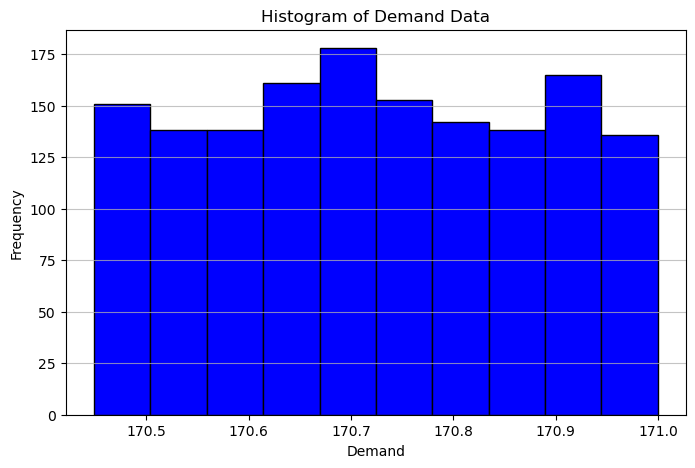

In [28]:
# Plot the histogram
plt.figure(figsize=(8, 5))  # Optional: set the figure size
plt.hist(demand, bins=10, color='blue', edgecolor='black')  # Customize bins and colors
plt.title('Histogram of Demand Data')  # Add a title
plt.xlabel('Demand')  # Label x-axis
plt.ylabel('Frequency')  # Label y-axis
plt.grid(axis='y', alpha=0.75)  # Add grid lines for better readability

# Show the plot
plt.show()